# Tesla Stock Price Prediction, Feature Pruning
### Second Semester Capstone

In this notebook I'm experimenting with using fewer features, but also adding more lookback (i.e. instead of using features from point t-1, also include t-2, t-3, etc). So far I've received about 7.1% error using just the Google Trends data and a lookback of 5 (going back to point t-5), and attempts with higher lookback, such as 10, increase the amount of error.

In [49]:
import pandas as pd
import numpy as np
#tf.compat.v1.disable_v2_behavior()
from math import sqrt, floor
from matplotlib import pyplot
from statistics import mean

# LSTM Application

## Preparing Data

In [50]:
# Loading Preprocessed Data File
df = pd.read_csv("../Data/preprocessed.csv",usecols=['Date','Close','Tesla Trend'], parse_dates=['Date'],index_col=0)
df.dropna(inplace=True)

print(df.shape)
df.head()

(2699, 2)


,Close,Tesla Trend
Date,,
2010-07-01,4.392,7.00
2010-07-02,3.840,6.09
2010-07-06,3.222,2.10
2010-07-07,3.160,3.78
2010-07-08,3.492,5.60


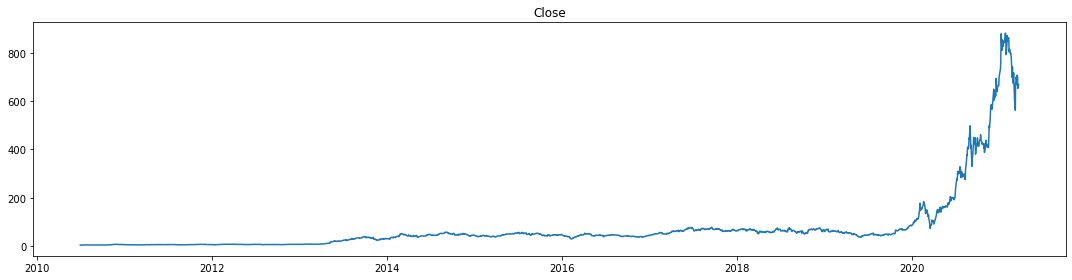

In [51]:
dates = df.index.to_numpy()
pyplot.figure(figsize=(15,4))

pyplot.plot(dates, df["Close"], label="Close")
pyplot.title("Close")

pyplot.tight_layout()
pyplot.show()

### Function For Converting Time Series Data For Supervised Learning

In [52]:
# convert series to supervised learning
# developed in this blog post https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
	# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### Converting Data for Supervised Learning

In [124]:
from sklearn.preprocessing import MinMaxScaler

values = df.values
# integer encoding of labels (not using yet here since we don't have non-numerical data)
#encoder = LabelEncoder()
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 5, 1)

# Drop Columns of Variables We Aren't Predicting
# We want all variables we're including in the model for t-1 and only the variable we're predicting for time t
#reframed.drop(reframed.columns[[39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,22,21,20]], axis=1, inplace=True)
reframed.drop(reframed.columns[[11]], axis=1, inplace=True)
print(reframed.shape)
reframed.head()

(2694, 11)


,var1(t-5),var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t)
5,0.001400,0.060606,0.000773,0.051414,0.000070,0.011111,0.000000,0.028081,0.000377,0.046465,0.000364
6,0.000773,0.051414,0.000070,0.011111,0.000000,0.028081,0.000377,0.046465,0.000364,0.037273,0.000284
7,0.000070,0.011111,0.000000,0.028081,0.000377,0.046465,0.000364,0.037273,0.000284,0.026667,0.000532
8,0.000000,0.028081,0.000377,0.046465,0.000364,0.037273,0.000284,0.026667,0.000532,0.020303,0.000918
9,0.000377,0.046465,0.000364,0.037273,0.000284,0.026667,0.000532,0.020303,0.000918,0.044343,0.000930


In [125]:
values = reframed.values
# split into train, test, and prediction sets
n_predict = 365 # We are predicting 365 days
n_train = floor((len(values)-n_predict) * 0.80) # 80% of the data is currently used for train (can be adjusted)
train = values[:n_train, :]
test = values[n_train:len(values)-n_predict, :] # What's left is used for test
predict = values[len(values)-n_predict:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
predict_X, predict_y = predict[:, :-1], predict[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
predict_X = predict_X.reshape((predict_X.shape[0], 1, predict_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, predict_X.shape, predict_y.shape)

(1863, 1, 10) (1863,) (466, 1, 10) (466,) (365, 1, 10) (365,)


## Running Model

In [126]:
# Import keras libraries
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.constraints import NonNeg
#from tensorflow.keras.callbacks import Callback

# Unused
"""
class stopAtLossValue(Callback):
        def on_batch_end(self, batch, logs={}):
            THR = 0.009 #Assign THR with the value at which you want to stop training.
            if logs.get('loss') <= THR:
                 self.model.stop_training = True
"""

"\nclass stopAtLossValue(Callback):\n        def on_batch_end(self, batch, logs={}):\n            THR = 0.009 #Assign THR with the value at which you want to stop training.\n            if logs.get('loss') <= THR:\n                 self.model.stop_training = True\n"

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 50)                12200     
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 12,251
Trainable params: 12,251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
5/5 - 4s - loss: 0.0290 - accuracy: 0.0000e+00 - val_loss: 0.0500 - val_accuracy: 0.0000e+00 - 4s/epoch - 735ms/step
Epoch 2/150
5/5 - 0s - loss: 0.0222 - accuracy: 0.0000e+00 - val_loss: 0.0330 - val_accuracy: 0.0000e+00 - 152ms/epoch - 30ms/step
Epoch 3/150
5/5 - 0s - loss: 0.0183 - accuracy: 0.0000e+00 - val_loss: 0.0187 - val_accuracy: 0.0000e+00 - 154ms/epoch - 31ms/step
Epoch 4/150
5/5 - 0s - loss: 0.0154 - accuracy: 0.0000e

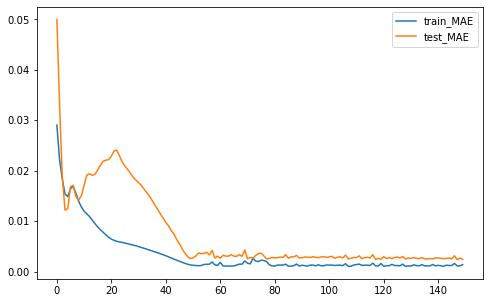

In [127]:
# Design Network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))
model.add(Dense(1, activation="linear", kernel_constraint=NonNeg()))

model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
model.summary()

# fit network
# epochs = how long you're running it
# batch_size = number of training samples to use in an epoch
history = model.fit(train_X, train_y, epochs=150, batch_size=450, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.figure(figsize=(8,5))
pyplot.plot(history.history['loss'], label='train_MAE')
pyplot.plot(history.history['val_loss'], label='test_MAE')
pyplot.legend()
pyplot.show()

### Prediction

In [128]:
# make a prediction
yhat = model.predict(predict_X)
predict_X_2D = predict_X.reshape((predict_X.shape[0], predict_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, predict_X_2D[:, 1:]), axis=1)
inv_yhat = scaler.fit(inv_yhat).inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
predict_y = predict_y.reshape((len(predict_y), 1))
inv_y = np.concatenate((predict_y, predict_X_2D[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

### Metrics

In [129]:
from sklearn.metrics import mean_squared_error

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
normalized_rmse = rmse/(mean(inv_y))
print('Normalized RMSE: %.3f' % normalized_rmse)

Test RMSE: 0.029
Normalized RMSE: 0.071


In [130]:
# Finding the predicted quarterly maximums
dates = dates[len(dates)-n_predict:]

#maxes = [dates[np.argmax(yhat[0:89], axis=0)]]
#maxes_actual = [dates[np.argmax(predict_y[0:89], axis=0)]]
maxes = [
    dates[np.argmax(yhat[0:89], axis=0)], 
    dates[np.argmax(yhat[90:179], axis=0)+90], 
    dates[np.argmax(yhat[180:269], axis=0)+180], 
    dates[np.argmax(yhat[270:364], axis=0)+270]
]
maxes_actual = [
    dates[np.argmax(predict_y[0:89], axis=0)], 
    dates[np.argmax(predict_y[90:179], axis=0)+90], 
    dates[np.argmax(predict_y[180:269], axis=0)+180], 
    dates[np.argmax(predict_y[270:364], axis=0)+270]
]

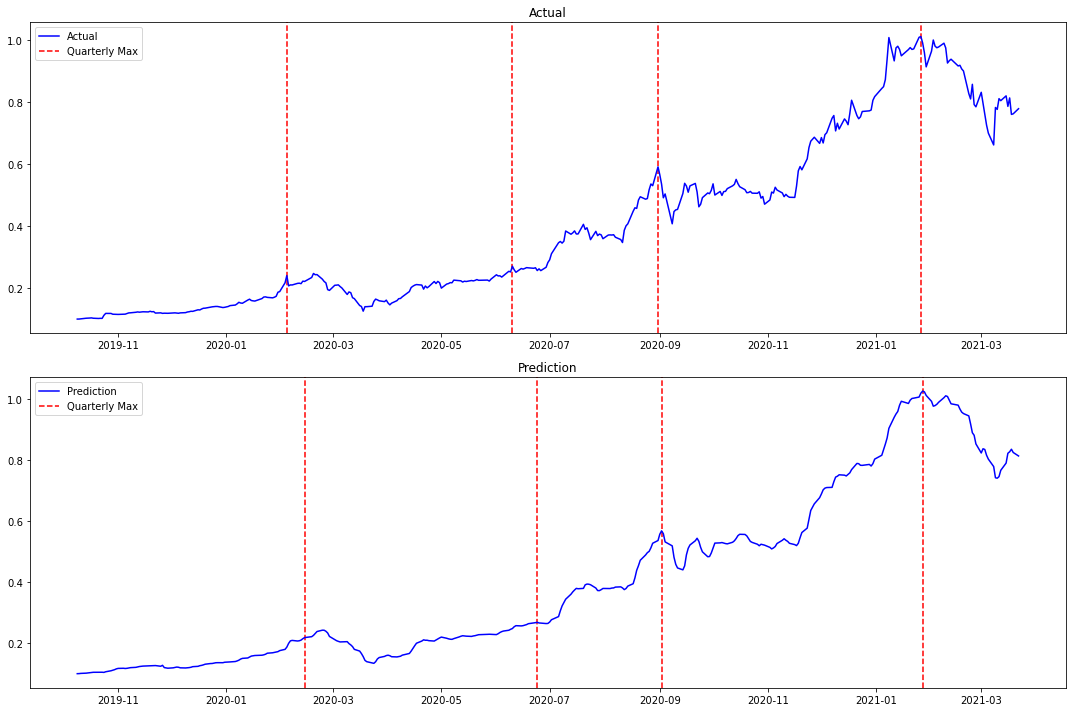

In [131]:
# Plot of Prediction vs Actual
pyplot.figure(figsize=(15,10))

pyplot.subplot(2, 1, 1)
pyplot.plot(dates, inv_y, color='b', label="Actual", zorder=2)
# Adding dashed lines for the quarterly maximums
pyplot.axvline(x=maxes_actual[0], color='r', linestyle='--', label='Quarterly Max', zorder=1)
for xc in maxes_actual[1:]:
    pyplot.axvline(x=xc, color='r', linestyle='--', zorder=1)
pyplot.legend(loc='upper left')
pyplot.title("Actual")

pyplot.subplot(2, 1, 2)
pyplot.plot(dates, inv_yhat, color='b', label="Prediction", zorder=2)
# Adding dashed lines for the quarterly maximums
pyplot.axvline(x=maxes[0], color='r', linestyle='--', label='Quarterly Max', zorder=1)
for xc in maxes[1:]:
    pyplot.axvline(x=xc, color='r', linestyle='--', zorder=1)
pyplot.legend(loc='upper left')
pyplot.title("Prediction")

pyplot.tight_layout()
pyplot.show()

In [132]:
# Printing the dates of each quarterly maximum
for i in range(len(maxes)):
    print("Q%i Max: %s" %(i+1, maxes[i][0]))
    print("Q%i Actual Max: %s" %(i+1, maxes_actual[i][0]))
    print("Diff: %s" %abs((maxes_actual[i][0]-maxes[i][0]).astype('timedelta64[D]')))

Q1 Max: 2020-02-14T00:00:00.000000000
Q1 Actual Max: 2020-02-04T00:00:00.000000000
Diff: 10 days
Q2 Max: 2020-06-24T00:00:00.000000000
Q2 Actual Max: 2020-06-10T00:00:00.000000000
Diff: 14 days
Q3 Max: 2020-09-02T00:00:00.000000000
Q3 Actual Max: 2020-08-31T00:00:00.000000000
Diff: 2 days
Q4 Max: 2021-01-27T00:00:00.000000000
Q4 Actual Max: 2021-01-26T00:00:00.000000000
Diff: 1 days


In [133]:
import shap

# Create explainer for SHAP feature analysis
explainer = shap.GradientExplainer(model, train_X)
shap_values = explainer.shap_values(predict_X)
shap.initjs()

# Data has to be converted to 2D
shap_values_2D = shap_values[0].reshape(-1,10)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


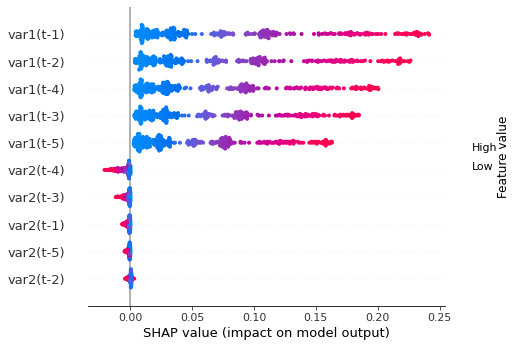

In [134]:
# Plot of Feature Importance
shap.summary_plot(shap_values_2D, features=predict_X_2D, feature_names=reframed.columns)